In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
from cmdstanpy import CmdStanModel, set_cmdstan_path
import arviz as az

In [2]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')

In [3]:
X = pd.read_csv("../Datasets/variables_to_select.csv")

In [4]:
rows_to_drop_Y = Y[Y['Count_180'].isna()].index

# Remove corresponding rows from dataset X
X = X.drop(index=rows_to_drop_Y)
Y = Y.drop(index=rows_to_drop_Y)

# If you want to reset the index after dropping rows
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

In [5]:
Y.head

<bound method NDFrame.head of       Count_180  idSensore  Year  Month
0             0       5707  2010      4
1             0       5707  2010      5
2             7       5707  2010      6
3            12       5707  2010      7
4             1       5707  2010      8
...         ...        ...   ...    ...
3803          3      12020  2022      6
3804          0      12020  2022      7
3805          0      12020  2022      8
3806          0      12020  2022      9
3807          0      12020  2022     10

[3808 rows x 4 columns]>

In [6]:
stations = Y['idSensore']
years = Y['Year'] - 2009
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations = transformed_stations

In [ ]:
base_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;

    fix_eff = X * beta;

    lambda = exp(fix_eff);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

}
generated quantities{
 vector[N] log_lik;
 for(i in 1:N){
   log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]) ;
}
}

"""

stan_file = "./stan/base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

model_base = CmdStanModel(stan_file=stan_file)

In [9]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X
}


fit_base = model_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_base_az = az.from_cmdstanpy(fit_base)

16:24:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:24:16 - cmdstanpy - INFO - CmdStan done processing.


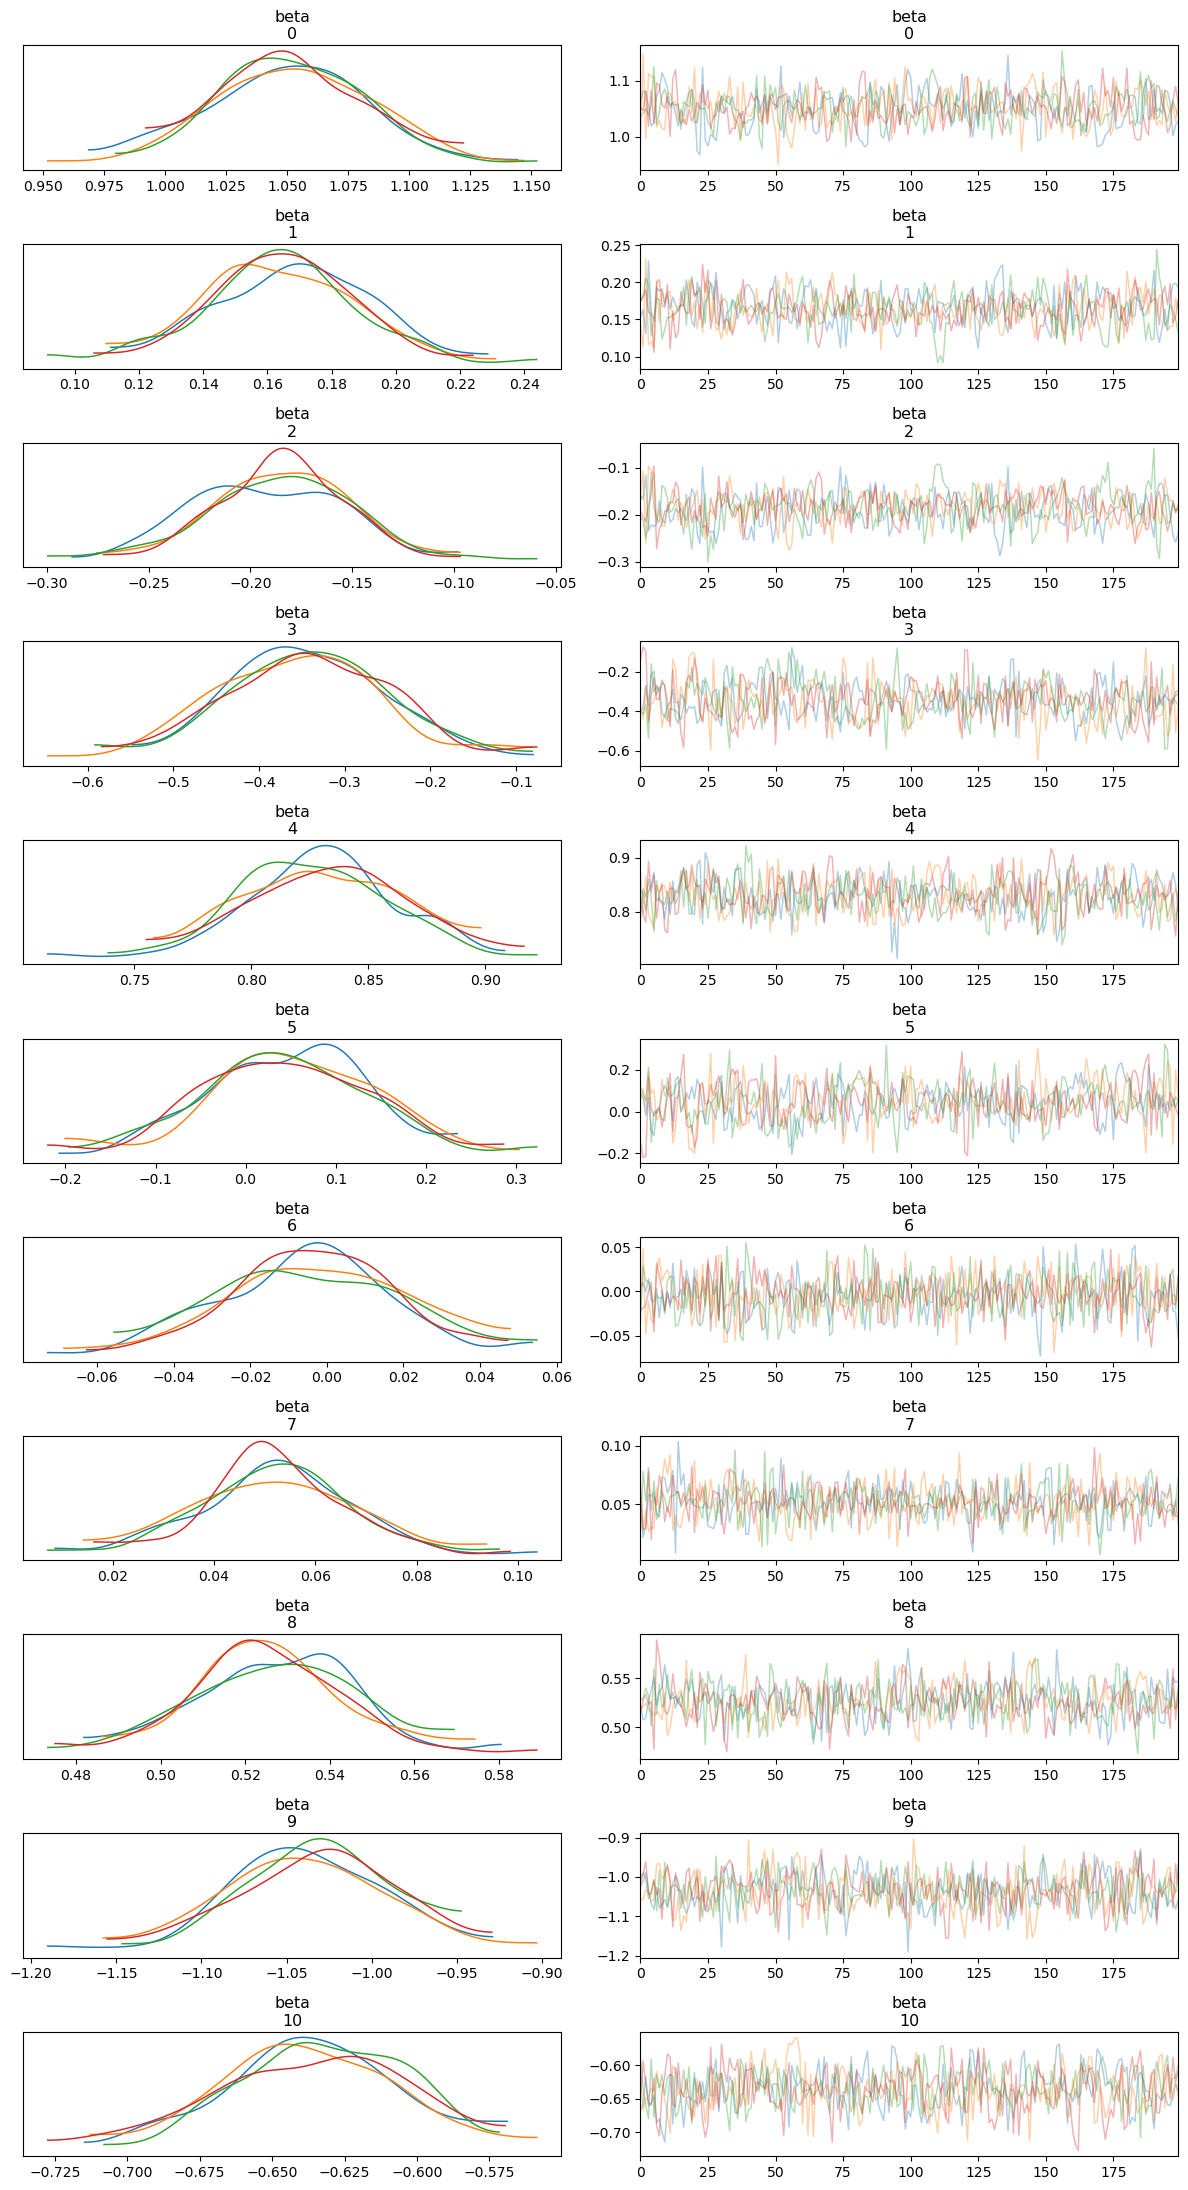

In [10]:
az.plot_trace(posterior_base_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [11]:
log_lik = fit_base.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


In [12]:
# Crea un oggetto InferenceData contenente log_lik
#inference_data = az.from_cmdstanpy(fit, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_base, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_base, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -5432.88   117.49
p_waic       37.44        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5433.03   117.49
p_loo       37.59        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3808  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



Now we remove some variables, through two methods:\
    1. Variable selection through **SSVS**\
    2. Hard shrinkage in the posterior of the betas   
    
The code for the SSVS is on R in its folder, while the hard shrinkage will be in this file.

Given the SSVS paradigm, the covariates to remove are *max_consecutive_highwind_days*, *Densità*, *count_highwind*

In [ ]:
##Code for hard shrinkage, hopefully same result

In [13]:
X = X.drop(columns=['max_consecutive_highwind_days', 'Densità', 'count_highwind'])

In [14]:
var_sel_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;

    fix_eff = X * beta;

    lambda = exp(fix_eff);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

}
generated quantities{
 vector[N] log_lik;
 for(i in 1:N){
   log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]) ;
}
}

"""

stan_file = "./stan/var_sel_base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

var_sel_base = CmdStanModel(stan_file=stan_file)

16:25:06 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan\var_sel_base.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\var_sel_base.exe
16:25:29 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\var_sel_base.exe


In [15]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X
}


fit_var_sel = var_sel_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_val_sel_az = az.from_cmdstanpy(fit_var_sel)

16:25:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:25:36 - cmdstanpy - INFO - CmdStan done processing.


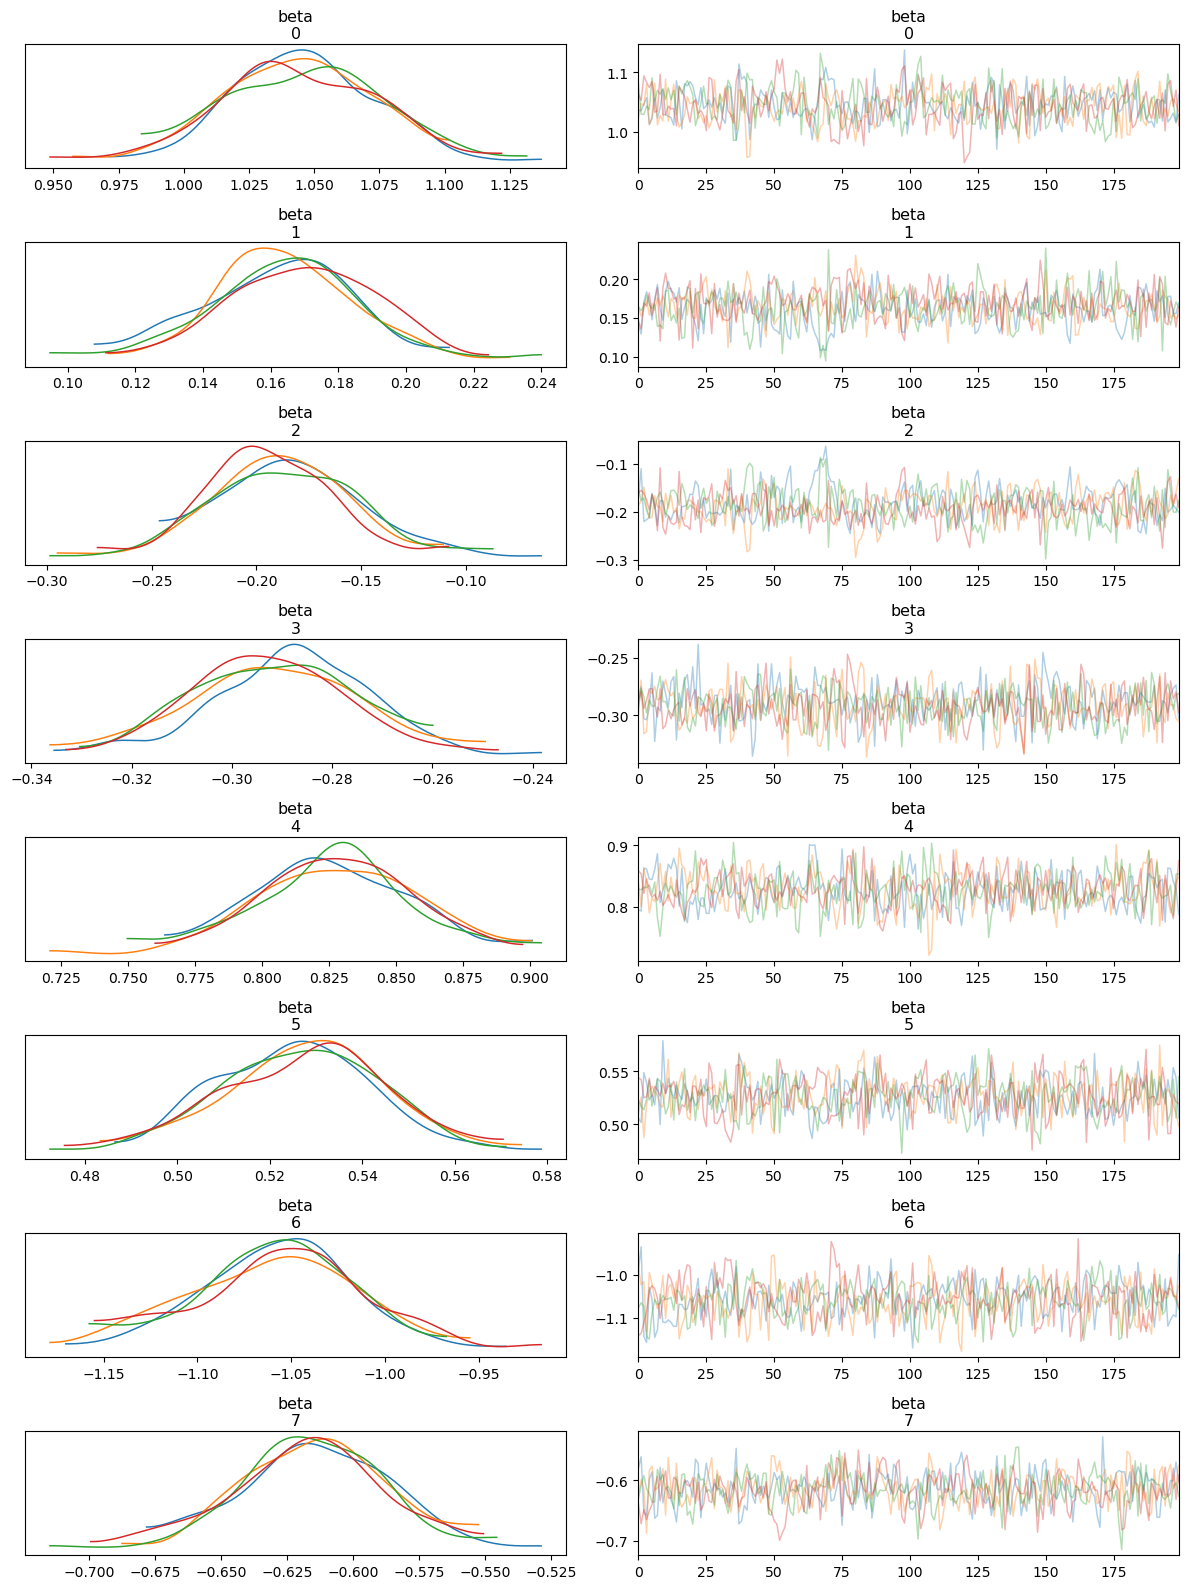

In [16]:
az.plot_trace(posterior_val_sel_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [17]:
log_lik = fit_var_sel.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


In [18]:
# Crea un oggetto InferenceData contenente log_lik
#inference_data = az.from_cmdstanpy(fit, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_var_sel, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_var_sel, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -5431.34   117.25
p_waic       25.65        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5431.50   117.26
p_loo       25.81        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3808  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



# Fit improvement
The threshold of 180 is very unlikely to be overcomed, with respect to the 120-threshold.\
This result in the presence of more zeros, and indeed *too much zeros*.\
The method for overcoming this issue is the **zero inflated Poisson** and the following is the code to implement this metodologies.

In [ ]:
#Code for improve the fit

In [8]:
zip_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  real<lower=0, upper=1> theta; // Probability of excess zeros
}

transformed parameters {
  vector[N] lambda;
  vector[N] fix_eff;

  fix_eff = X * beta;
  lambda = exp(fix_eff);
}

model {
  beta ~ normal(0, 2);
  theta ~ beta(0.5, 0.5); // Prior for excess zeros probability
  
  for (n in 1:N) {
    if (y[n] == 0)
      target += log_sum_exp(bernoulli_lpmf(1 | theta),
                            bernoulli_lpmf(0 | theta)
                              + poisson_lpmf(y[n] | lambda));
    else
      target += bernoulli_lpmf(0 | theta)
                  + poisson_lpmf(y[n] | lambda);
  }
}

generated quantities {
  vector[N] log_lik;
  for (n in 1:N) {
    if (y[n] == 0) {
      log_lik[n] = log_sum_exp(bernoulli_lpmf(1 | theta),
                            bernoulli_lpmf(0 | theta)
                              + poisson_lpmf(y[n] | lambda));
    } else {
      log_lik[n] = bernoulli_lpmf(0 | theta)
                  + poisson_lpmf(y[n] | lambda);
    }
  }
}

"""

stan_file = "./stan/zip.stan"

with open(stan_file, "w") as f:
    print(zip_model, file=f)

model_zip = CmdStanModel(stan_file=stan_file)

16:00:27 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\zip.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\zip.exe
16:00:55 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\zip.exe


In [ ]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X
}


fit_zip = model_zip.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_zip_az = az.from_cmdstanpy(fit_zip)

16:00:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [ ]:
az.plot_trace(posterior_zip_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
log_lik = fit_zip.stan_variable("log_lik")
print(type(log_lik))

In [ ]:
# Crea un oggetto InferenceData contenente log_lik
inference_zip = az.from_cmdstanpy(fit_zip, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(inference_zip, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(inference_zip, var_name="log_lik")
print("LOO: ", loo_result)

### Next step:
We add the factor accounting for different years.

In [19]:
year_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;

  array[N] int<lower=1> year;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;

    fix_eff = X * beta;
    intercept = xi[year];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
}
generated quantities{
 vector[N] log_lik;
 for(i in 1:N){
   log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]) ;
}
}

"""

stan_file = "./stan/years.stan"

with open(stan_file, "w") as f:
    print(year_model, file=f)

model_year = CmdStanModel(stan_file=stan_file)

16:26:47 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan\years.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\years.exe
16:27:12 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\years.exe


In [22]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X
}


fit_years = model_year.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_years_az = az.from_cmdstanpy(fit_years)

16:27:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:28:03 - cmdstanpy - INFO - CmdStan done processing.


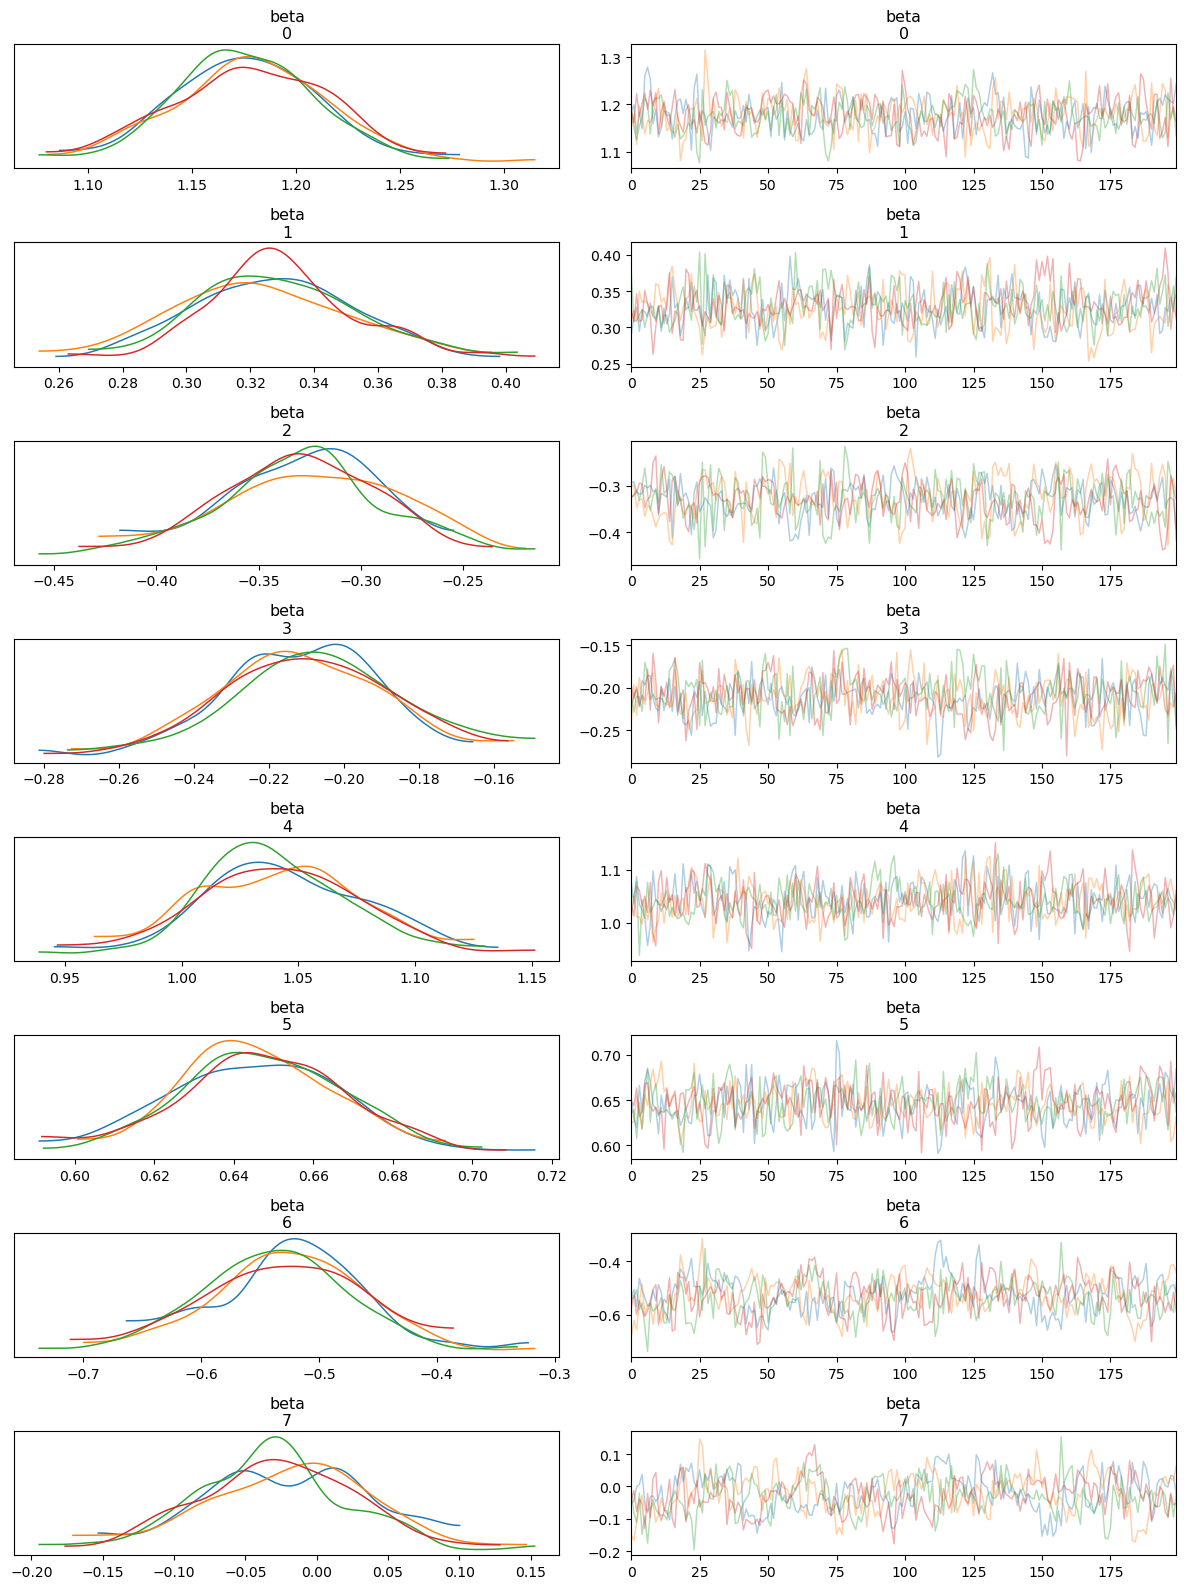

In [23]:
az.plot_trace(posterior_years_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [24]:
log_lik = fit_years.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


In [27]:
# Crea un oggetto InferenceData contenente log_lik
#inference_years = az.from_cmdstanpy(fit_years, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_years, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_years, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -4814.94   110.81
p_waic       59.06        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4815.22   110.81
p_loo       59.34        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3807  100.0%
 (0.5, 0.7]   (ok)          1    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



After this upgrade, we account for the differences in the *stations* factor.

In [34]:
station_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> year;
  array[N] int<lower=1> stations;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
  vector[nstations] eta;//For the stations
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;

    fix_eff = X * beta;
    intercept = xi[year] + eta[stations];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
  eta ~ normal(0, 2);
}
generated quantities{
 vector[N] log_lik;
 for(i in 1:N){
   log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]) ;
}
}

"""

stan_file = "./stan/station.stan"

with open(stan_file, "w") as f:
    print(station_model, file=f)

model_station = CmdStanModel(stan_file=stan_file)

16:33:09 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan\station.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\station.exe
16:33:34 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\station.exe


In [35]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X
}


fit_stations = model_station.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_station_az = az.from_cmdstanpy(fit_stations)

16:33:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:35:01 - cmdstanpy - INFO - CmdStan done processing.


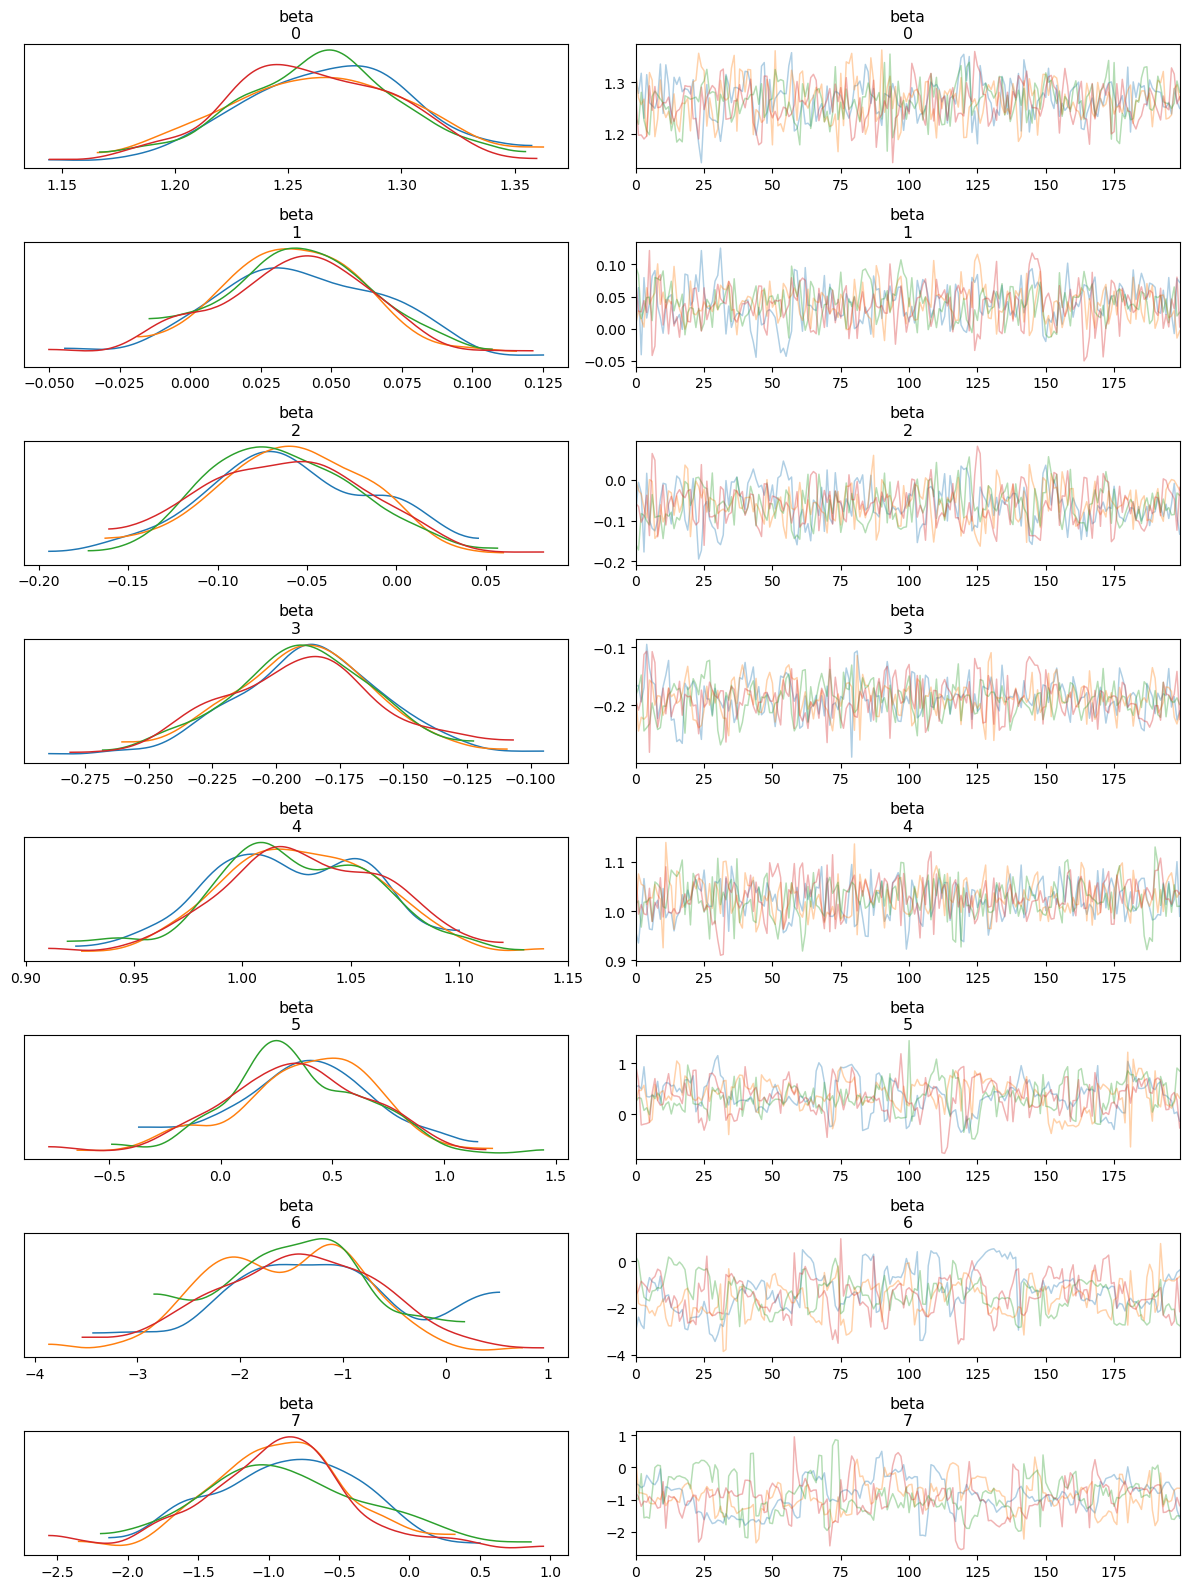

In [36]:
az.plot_trace(posterior_station_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [32]:
log_lik = fit_stations.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


In [38]:
# Crea un oggetto InferenceData contenente log_lik
#inference_stations = az.from_cmdstanpy(fit_stations, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_stations, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_stations, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3837.17    85.19
p_waic      105.15        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3837.95    85.21
p_loo      105.94        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3803   99.9%
 (0.5, 0.7]   (ok)          5    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



Now, we should take into account the spatial dependance of the model, through an appropriate space model (main folder with R files) and put again this ideas into this model.

In [ ]:
#Space model